## What is VAR (Vector Autoregression)

Vector Autoregression (VAR) is a multivariate forecasting algorithm that is used when two or more time series influence each other.

That means, the basic requirements in order to use VAR are:

  * You need atleast two time series (variables)
  * The time series should influence each other.
  
It is considered as an Autoregressive model because, each variable (Time Series) is modeled as a function of the past values, that is the predictors are nothing but the lags (time delayed value) of the series.

The primary difference is those models are uni-directional, where, the predictors influence the Y and not vice-versa. Whereas, Vector Auto Regression (VAR) is bi-directional. That is, the variables influence each other.

In [65]:
import data_prep_helper
from statsmodels.tsa.vector_ar.var_model import VAR
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [66]:
do = data_prep_helper.ChartData()

In [67]:
do.apply_boll_bands("bitcoin_hist", append_chart=True)

In [68]:
corr_df = do.chart_df

In [69]:
cols = corr_df.columns

In [84]:
#creating the train and validation set
train = corr_df[:int(0.8*(len(corr_df)))]
valid = corr_df[int(0.8*(len(corr_df))):]


In [85]:
months = train.index.month
dummy_months = pd.get_dummies(months)
dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
dummy_months.index = train.index




train['bitcoin_Price_prev_week'] = train['bitcoin_Price'].shift(8)
train['bitcoin_Price_prev_month'] = train['bitcoin_Price'].shift(31)
train['alibaba_Price_prev_month'] = train['alibaba_Price'].shift(31)
train['alibaba_Price_prev_week'] = train['alibaba_Price'].shift(8)
train['amazon_Price_prev_month'] = train['amazon_Price'].shift(31)
train['googl_Price_prev_month'] = train['googl_Price'].shift(31)
train['googl_Price_prev_week'] = train['googl_Price'].shift(8)

train['bitcoin_trends_prev_month'] = train['bitcoin_Google_Trends'].shift(31)
train['bitcoin_trends_prev_week'] = train['bitcoin_Google_Trends'].shift(8)
train['cryptocurrency_trends_prev_month'] = train['cryptocurrency_Google_Trends'].shift(31)
train['cryptocurrency_trends_prev_week'] = train['cryptocurrency_Google_Trends'].shift(8)
train['economy_pos_prev_month'] = train['economy_pos_sents'].shift(31)


train.fillna(0, inplace=True)
 
train = pd.concat([train, dummy_months], axis=1)


In [86]:
months = valid.index.month
dummy_months = pd.get_dummies(months)
dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
dummy_months.index = valid.index



valid['bitcoin_Price_prev_week'] = valid['bitcoin_Price'].shift(8)
valid['bitcoin_Price_prev_month'] = valid['bitcoin_Price'].shift(31)
valid['alibaba_Price_prev_month'] = valid['alibaba_Price'].shift(31)
valid['alibaba_Price_prev_week'] = valid['alibaba_Price'].shift(8)
valid['amazon_Price_prev_month'] = valid['amazon_Price'].shift(31)
valid['googl_Price_prev_month'] = valid['googl_Price'].shift(31)
valid['googl_Price_prev_week'] = valid['googl_Price'].shift(8)

valid['bitcoin_trends_prev_month'] = valid['bitcoin_Google_Trends'].shift(31)
valid['bitcoin_trends_prev_week'] = valid['bitcoin_Google_Trends'].shift(8)
valid['cryptocurrency_trends_prev_month'] = valid['cryptocurrency_Google_Trends'].shift(31)
valid['cryptocurrency_trends_prev_week'] = valid['cryptocurrency_Google_Trends'].shift(8)
valid['economy_pos_prev_month'] = valid['economy_pos_sents'].shift(31)


valid = pd.concat([valid, dummy_months], axis=1)

In [87]:
train_slice = train[[
                   'bitcoin_Price',
                   'bitcoin_30_day_ma',
                   'bitcoin_boll_upp',
                   'bitcoin_boll_low',
                   'alibaba_Price',
                   'googl_Price',
                   'bitcoin_Google_Trends',
                   'cryptocurrency_Google_Trends',
                   'month-1', 'month-2'
                   ]].fillna(0)

valid_slice = valid[[
                   'bitcoin_Price',
                   'bitcoin_30_day_ma',
                   'bitcoin_30_day_std',
                   'bitcoin_boll_upp',
                   'bitcoin_boll_low',
                   'alibaba_Price',
                   'googl_Price',
                   'bitcoin_Google_Trends',
                   'cryptocurrency_Google_Trends',
                   'month-1', 'month-2'
                   ]].fillna(0)

model = VAR(endog=train_slice)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

#converting predictions to dataframe

cols = train.columns
valid_pred = pd.DataFrame(prediction, columns=train_slice.columns, index=valid_slice.index)

#check rmse
for i in train_slice.columns:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(valid_pred[i], valid_slice[i])))

rmse value for bitcoin_Price is :  1888.6023402164224
rmse value for bitcoin_30_day_ma is :  1641.8092858940256
rmse value for bitcoin_boll_upp is :  1854.3755620374172
rmse value for bitcoin_boll_low is :  1752.8193878152213
rmse value for alibaba_Price is :  18.49597897566684
rmse value for googl_Price is :  161.05609134215229
rmse value for bitcoin_Google_Trends is :  537.1844722596993
rmse value for cryptocurrency_Google_Trends is :  87.4166318858425
rmse value for month-1 is :  0.27803885621871643
rmse value for month-2 is :  0.3152946673330543


In [88]:
valid_pred.to_csv("var_pred.csv")

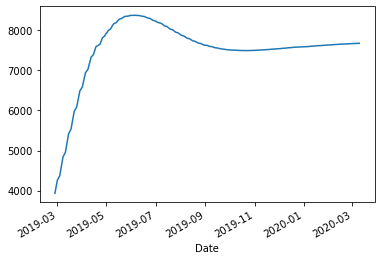

In [89]:
valid_pred["bitcoin_Price"].plot()

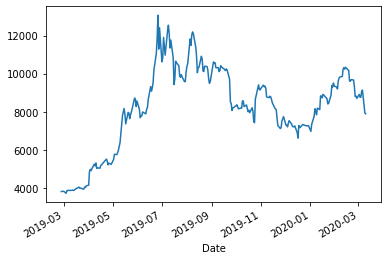

In [90]:
valid_slice["bitcoin_Price"].plot()

In [75]:
train["bitcoin_Price"] = train["bitcoin_Price"].diff()
train["bitcoin_30_day_ma"] = train["bitcoin_30_day_ma"].diff()
train["bitcoin_30_day_std"] = train["bitcoin_30_day_std"].diff()
train["bitcoin_boll_upp"] = train["bitcoin_boll_upp"].diff()
train["bitcoin_boll_low"] = train["bitcoin_boll_low"].diff()
train["googl_Price"] = train["googl_Price"].diff()

train=train.dropna()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: 'bitcoin_30_day_ma'

In [76]:
df_cols = ["bitcoin_Price", 
           "bitcoin_30_day_ma", 
           "bitcoin_30_day_std", 
           "bitcoin_boll_upp",
           "bitcoin_boll_low",
           "bitcoin_Google_Trends", 
           "googl_Price", 
           "cryptocurrency_Google_Trends"]

valid_01 = valid[df_cols]
model = VAR(endog=train[df_cols])
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid_01))

#converting predictions to dataframe

cols = df_cols
valid_pred = pd.DataFrame(prediction, columns=cols, index=valid_index)

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(valid_pred[i], valid[i])))

KeyError: "['bitcoin_30_day_std', 'bitcoin_boll_low', 'bitcoin_boll_upp', 'bitcoin_30_day_ma'] not in index"

In [69]:
valid_pred["bitcoin_Price"].head()

Date
2019-02-26    130.080958
2019-02-27    -98.956305
2019-02-28     99.357698
2019-03-01    -75.285316
2019-03-04     50.283790
Name: bitcoin_Price, dtype: float64

In [15]:
#make final predictions
num_forcast = 30
 
model = VAR(endog=corr_df)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=num_forcast)

yhat_df = pd.DataFrame(yhat, columns=cols)

forecast_dates = pd.date_range(start=corr_df.index[-1], periods=num_forcast+1)[1:]

yhat_df = yhat_df.set_index(forecast_dates)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/conda/lib/python3.7/site-packages/statsmodels/base/wrapper.py:36: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



ValueError: Shape of passed values is (5, 20), indices imply (5, 44)

In [25]:
fig = make_subplots(
    rows=2, 
    cols=1, 
    shared_xaxes=True, 
    vertical_spacing=0.2,
    subplot_titles=(["Bitcoin Price Chart<br>with Validation<br>and Forecast",
                     "Bitcoin 30-day-Mean"])
)

fig.add_trace(go.Scatter(x=corr_df.index, 
                         y=corr_df['bitcoin_Price'],
                         name="BITCOIN Closing Price"), row=1, col=1)

fig.add_trace(go.Scatter(x=valid_pred.index, 
                         y=valid_pred['bitcoin_Price'],
                         name="BITCOIN Validation Prediction"), row=1, col=1)

fig.add_trace(go.Scatter(x=yhat_df.index, 
                         y=yhat_df['bitcoin_Price'],
                         name="BITCOIN Current Forecast"), row=1, col=1)

fig.add_trace(go.Scatter(x=corr_df.index, 
                         y=corr_df['bitcoin_30_day_ma'],
                         name="BITCOIN 30 Closing Price"), row=2, col=1)

fig.add_trace(go.Scatter(x=valid_pred.index, 
                         y=valid_pred['bitcoin_30_day_ma'],
                         name="Validation Prediction"), row=2, col=1)

fig.add_trace(go.Scatter(x=yhat_df.index, 
                         y=yhat_df['bitcoin_30_day_ma'],
                         name="Current Forecast"), row=2, col=1)

fig.update_layout(height=1000, width=1500, title_text="Bitcoin Prediction using VAR (Vector Autoregression)")


NameError: name 'yhat_df' is not defined